## Tutorial for Loading the Breast Cancer 10X Genomics Spatial Transcriptomics Dataset

1. Go to this website: https://support.10xgenomics.com/spatial-gene-expression/datasets/1.2.0/Parent_Visium_Human_BreastCancer
2. Download the following files:
- 'Image'
- 'Feature / cell matrix (filtered)'
- 'Clustering analysis'
- 'Spatial imaging data'
- 'Summary CSV'

In [1]:
import csv
import gzip
import os
import os.path as osp
import numpy as np
import scipy.io

data_dir = './data'
mat_dir = osp.join(data_dir, 'filtered_feature_bc_matrix') # Decompressed 'feature/cell matrix (filtered)' file
mat_path = osp.join(mat_dir, 'matrix.mtx.gz')
features_path = osp.join(mat_dir, 'features.tsv.gz')
barcodes_path = osp.join(mat_dir, 'barcodes.tsv.gz')

In [2]:
mat = scipy.io.mmread(mat_path).todense() # (36601, 4325)
feature_ids = [row[0] for row in csv.reader(gzip.open(features_path, 'rt'), delimiter='\t')] # Ensembl IDs
gene_names = [row[1] for row in csv.reader(gzip.open(features_path, 'rt'), delimiter='\t')] # Gene Names
feature_types = [row[2] for row in csv.reader(gzip.open(features_path, 'rt'), delimiter='\t')] # "Gene Expression"
barcodes = [row[0] for row in csv.reader(gzip.open(barcodes_path, 'rt'), delimiter='\t')] # 4325 different positions

In [3]:
print('Number of Genes: {}, Number of Spots: {}'.format(*mat.shape))

Number of Genes: 36601, Number of Spots: 4325


In [4]:
print('Ensembl IDs for Genes:')
print(feature_ids[:10]) # Just the first 100
assert(len(feature_ids) == mat.shape[0]) # Check that Ensembl IDs match up

Ensembl IDs for Genes:
['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092', 'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906', 'ENSG00000241860', 'ENSG00000241599', 'ENSG00000286448', 'ENSG00000236601']


In [5]:
print('Gene Names:')
print(gene_names[:10]) # Just the first 100
assert(len(gene_names) == mat.shape[0]) # Check that gene names match up

Gene Names:
['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3', 'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1']


In [6]:
# Tissue position list
tissue_pos_path = osp.join(data_dir, 'spatial/tissue_positions_list.csv')
barcode_to_pos = {}

with open(tissue_pos_path, 'r') as fh:
    reader = csv.reader(fh)
    
    # in_tissue = binary value indicating whether spot falls inside or outside of tissue
    for line in reader:
        barcode, in_tissue, row_coord, col_coord, pxl_col_in_fullres, pxl_row_in_full_res = line
        barcode_to_pos[line[0]] = np.array(line)[1:].astype(np.int32)

In [8]:
# Barcodes associated with each spot
print(list(barcode_to_pos.keys())[:10])
print(barcode_to_pos['ACGCCTGACACGCGCT-1'])

['ACGCCTGACACGCGCT-1', 'TACCGATCCAACACTT-1', 'ATTAAAGCGGACGAGC-1', 'GATAAGGGACGATTAG-1', 'GTGCAAATCACCAATA-1', 'TGTTGGCTGGCGGAAG-1', 'GCATCCTCTCCTATTA-1', 'GCGAGGGACTGCTAGA-1', 'TGGTACCGGCACAGCC-1', 'GCGCGTTTAAATCGTA-1']
[   1    0    0 3910 3159]


You can read more about the entries in 'tissue_positions_list.csv' here: https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/images

# Normalization + Variable Gene Selection

Based on Scanpy (https://scanpy.readthedocs.io/en/stable/)

In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [3]:
sc.set_figure_params(facecolor="white", figsize=(8,8))
sc.settings.verbosity = 3

Scanpy already has a function that automatically downloads and parses the open source spatial transcriptomics data on the 10X Genomics website: https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html

In [5]:
adata = sc.datasets.visium_sge(sample_id="Parent_Visium_Human_BreastCancer") # Our dataset
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-") # Prefix MT- marks mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True) # Calculates some Quality Control metrics

reading /Users/danieljeong/User/CMU/Courses/Spring 2021/Computational Genomics (02-710)/Final Project/CMU-Genomics-Final/data/Parent_Visium_Human_BreastCancer/filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/danieljeong/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:794: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  value_idx = self._prep_dim_index(value.index, attr)
/Users/danieljeong/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:891: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  names = self._prep_dim_index(names, "var")


In [6]:
print(adata.X.shape)
adata.X.todense() # Raw gene count representation

(4325, 36601)


matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

/Users/danieljeong/anaconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


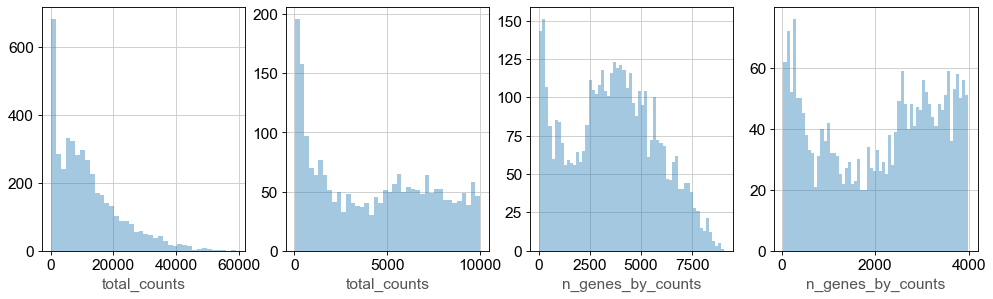

In [7]:
# Some histograms
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [8]:
# Filter out spots/cells with total counts in-between 5000 and 35000
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20] # Only take spots without overly expressed mitochondrial genes
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10) # Filter out genes with less than total counts of 10

filtered out 1268 cells that have less than 5000 counts
filtered out 161 cells that have more than 35000 counts
filtered out 18847 genes that are detected in less than 10 cells
Trying to set attribute `.var` of view, copying.


#cells after MT filter: 2896


In [9]:
sc.pp.normalize_total(adata, inplace=True) # Normalizes total count to median of total counts for observations (cells) before normalization
sc.pp.log1p(adata) # log-transform the expression data i.e. for X, calculate log(X+1)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [10]:
# Verify that there are 2000 genes selected
print(adata.var['highly_variable'].value_counts())

False    15754
True      2000
Name: highly_variable, dtype: int64


/Users/danieljeong/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  string_cols = [
... storing 'feature_types' as categorical
... storing 'genome' as categorical


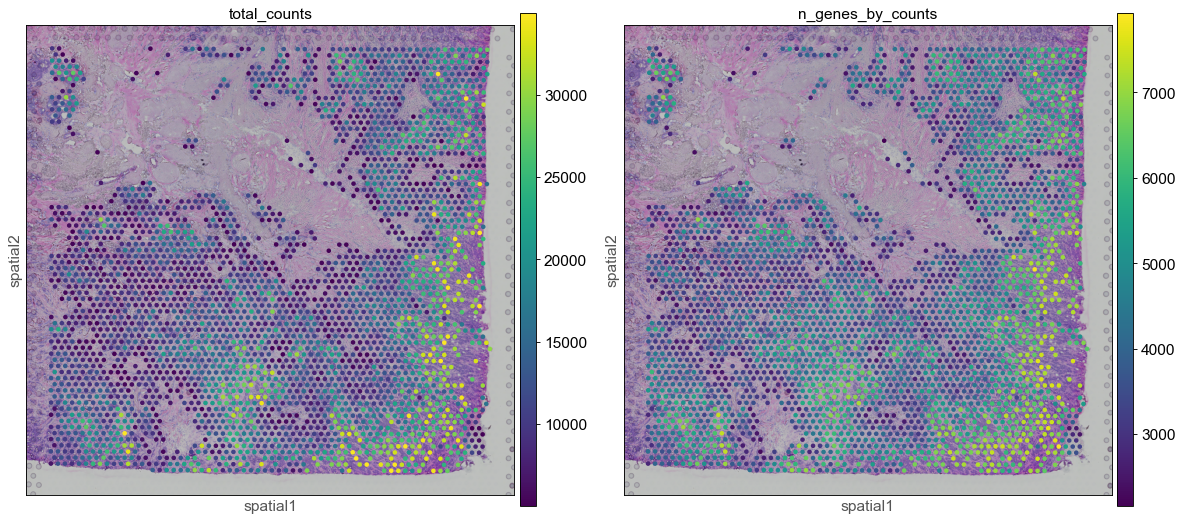

In [11]:
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

# CausalNex

In [31]:
from causalnex.structure import dynotears
import pandas as pd

In [53]:
# mat: genes x samples
# Get a toy dataframe (rows=samples, cols=genes, indices=timesteps)
samples = mat[:30,:30].T
sample_genes = gene_names[:30]
sample_df = pd.DataFrame(samples, columns=sample_genes)

# Transform data to 2 timestep lags, create structure model
ddt = dynotears.DynamicDataTransformer(2)
x, xlags = ddt.fit_transform(sample_df, return_df=False)
W = dynotears.from_numpy_dynamic(x, xlags)

In [1]:
# TODO: Fix network visualization

# from IPython.display import Image
# from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

# viz = plot_structure(
#     W,
#     graph_attributes={"scale": "0.5"},
#     all_node_attributes=NODE_STYLE.WEAK,
#     all_edge_attributes=EDGE_STYLE.WEAK)
# Image(viz.draw(format='png'))

In [57]:
# Explore DBN structure format
for val in W.adjacency():
    print(val)

('0_lag0', {})
('1_lag0', {})
('2_lag0', {})
('3_lag0', {})
('4_lag0', {})
('5_lag0', {})
('6_lag0', {})
('7_lag0', {})
('8_lag0', {})
('9_lag0', {})
('10_lag0', {})
('11_lag0', {})
('12_lag0', {})
('13_lag0', {})
('14_lag0', {'25_lag0': {'origin': 'unknown', 'weight': 0.07722318536309762}, '26_lag0': {'origin': 'unknown', 'weight': 2.6121025351487493e-05}})
('15_lag0', {})
('16_lag0', {'24_lag0': {'origin': 'unknown', 'weight': 0.4085663121095229}, '29_lag0': {'origin': 'unknown', 'weight': 1.1382963322265969}})
('17_lag0', {})
('18_lag0', {'24_lag0': {'origin': 'unknown', 'weight': 0.26704441559272063}})
('19_lag0', {})
('20_lag0', {})
('21_lag0', {})
('22_lag0', {})
('23_lag0', {'29_lag0': {'origin': 'unknown', 'weight': 4.846186237757162}})
('24_lag0', {'14_lag0': {'origin': 'unknown', 'weight': 0.019873158955101045}, '16_lag0': {'origin': 'unknown', 'weight': 3.1293873466479694e-05}, '18_lag0': {'origin': 'unknown', 'weight': 2.3274145687132982e-05}, '25_lag0': {'origin': 'unknown